#  A Product Recommendation System Built by User Purchase Histroy Using Word2Vec

In [1]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
from gensim.models import Word2Vec 
import matplotlib.pyplot as plt
%matplotlib inline
import umap
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel('data files/Online Retail.xlsx')
df.dropna(inplace=True)
df['StockCode']= df['StockCode'].astype(str)
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


# 1. Prepare Data for Word2Vec Model

In [2]:
customers = df["CustomerID"].unique().tolist()
len(customers)

4372

In [3]:
# shuffle customer ID's
random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.9*len(customers)))]

# split data into train and validation set
df_train = df[df['CustomerID'].isin(customers_train)]
df_test = df[~df['CustomerID'].isin(customers_train)]

In [4]:
# list to capture purchase history of the customers
purchases_train = []
purchases_test = []

# populate the list with the product codes
for i in tqdm(customers_train):
    temp = df_train[df_train["CustomerID"] == i]["StockCode"].tolist()
    purchases_train.append(temp)
    
for i in tqdm(df_test['CustomerID'].unique()):
    temp = df_test[df_test["CustomerID"] == i]["StockCode"].tolist()
    purchases_test.append(temp)

100%|██████████| 437/437 [00:00<00:00, 847.52it/s]


# 2. Build Word2Vec Model

In [5]:
model = Word2Vec(window = 10, sg = 1, hs = 0, negative = 10, alpha=0.03, min_alpha=0.0007, seed = 14)

model.build_vocab(purchases_train, progress_per=200)
model.train(purchases_train, total_examples = model.corpus_count, epochs=10, report_delay=1)

(3646584, 3682480)

In [6]:
# extract all vectors
X = model[model.wv.vocab]
X.shape

(3175, 100)

# 3. Visualize Word2Vec Embeddings

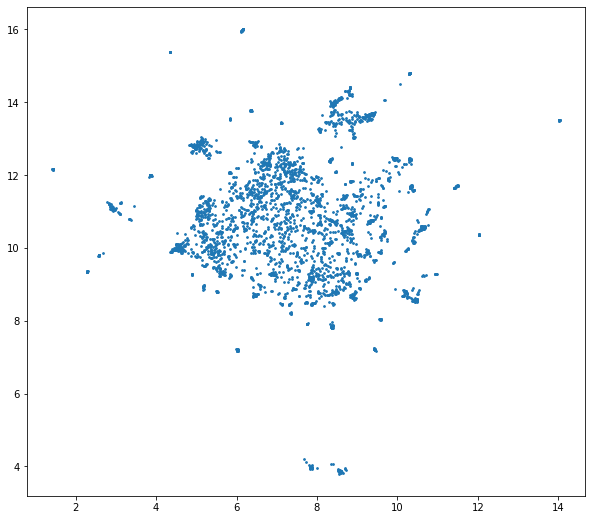

In [7]:
cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=42).fit_transform(X)

plt.figure(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

# 4. Start Recommending Products

In [8]:
products = df_train[["StockCode", "Description"]]

# remove duplicates
products.drop_duplicates(inplace=True, subset='StockCode', keep="last")

# create product-ID and product-description dictionary
products_dict = products.groupby('StockCode')['Description'].apply(list).to_dict()

In [17]:
# test the dictionary
products_dict['90019A']

['SILVER M.O.P ORBIT BRACELET']

##    &nbsp; &nbsp; 4.1. Single Product Recommendation  

In [10]:
def similar_products(v, n = 6):
    
    # extract most similar products for the input vector
    ms = model.similar_by_vector(v, topn= n+1)[1:]
    
    # extract name and similarity score of the similar products
    new_ms = []
    for j in ms:
        pair = (products_dict[j[0]][0], j[1])
        new_ms.append(pair)
        
    return new_ms        

In [11]:
similar_products(model['90019A'])

[('PINK BOUDICCA LARGE BRACELET', 0.8017971515655518),
 ('PINK HEART OF GLASS BRACELET', 0.7863891124725342),
 ('FLOWER GLASS GARLD NECKL36"AMETHYST', 0.7656751275062561),
 ('SILVER M.O.P ORBIT DROP EARRINGS', 0.7632349729537964),
 ('GREEN HEART OF GLASS BRACELET', 0.7584918141365051),
 ('GOLD/M.O.P PENDANT ORBIT NECKLACE', 0.7504233121871948)]

## &nbsp; &nbsp; 4.2. Multiple Products Recommendation  

In [12]:
# take the average of all the vectors of the products the user has bought so far 
# and use this new vector to find similar products. 
def aggregate_vectors(products):
    product_vec = []
    for i in products:
        try:
            product_vec.append(model[i])
        except KeyError:
            continue
    return np.mean(product_vec, axis=0)

In [13]:
len(purchases_test[0])

251

In [14]:
aggregate_vectors(purchases_test[0]).shape

(100,)

In [15]:
# give the user recommendation according to all his/her purchased products
similar_products(aggregate_vectors(purchases_test[0]))

[('SET/6 RED SPOTTY PAPER CUPS', 0.7024070024490356),
 ('SPACEBOY LUNCH BOX ', 0.6955424547195435),
 ('RED TOADSTOOL LED NIGHT LIGHT', 0.6930599808692932),
 ('ROUND SNACK BOXES SET OF 4 FRUITS ', 0.6900931596755981),
 ('SET/6 RED SPOTTY PAPER PLATES', 0.6879719495773315),
 ('PLASTERS IN TIN SPACEBOY', 0.6803625226020813)]

In [16]:
# give the user recommendation according to his/her latest 10 purchased products
similar_products(aggregate_vectors(purchases_test[0][-10:]))

[('ROUND SNACK BOXES SET OF 4 FRUITS ', 0.7191601991653442),
 ('LUNCH BOX WITH CUTLERY RETROSPOT ', 0.69889235496521),
 ('STRAWBERRY LUNCH BOX WITH CUTLERY', 0.695288360118866),
 ('POSTAGE', 0.6864078044891357),
 ('CHILDRENS APRON SPACEBOY DESIGN', 0.6698669195175171),
 ('SPACEBOY LUNCH BOX ', 0.6693841814994812)]